# Video Game Sales with Ratings

The dataset source can be found [here](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings).

## Context

Motivated by Gregory Smith's web scrape of VGChartz Video Games Sales, this data set simply extends the number of variables with another web scrape from Metacritic. Unfortunately, there are missing observations as Metacritic only covers a subset of the platforms. Also, a game may not have all the observations of the additional variables discussed below. Complete cases are ~ 6,900

## Content
Alongside the fields: Name, Platform, YearofRelease, Genre, Publisher, NASales, EUSales, JPSales, OtherSales, Global_Sales, we have:
- Critic_score - Aggregate score compiled by Metacritic staff
- Criticcount - The number of critics used in coming up with the Criticscore
- User_score - Score by Metacritic's subscribers
- Usercount - Number of users who gave the userscore
- Developer - Party responsible for creating the game
- Rating - The ESRB ratings

Idea of this project is to explore unsupervised learning methods and algorithms with a focus on clustering.

In [143]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import display
from matplotlib import animation
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## Global parameters setup

Executing methods that do some data transformation which involves randomness (i.e. sampling or data splitting) yields different result for each run. In order to have predictable results we can leverage the function argument called `random_state` and set it to a constant value (`randomness_id`).

In [144]:
# @formatter:off
# %matplotlib inline
# @formatter:on
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128
randomness_id = 5100
np.random.seed(randomness_id)

In [145]:
def remove_outliers(df):
    filtered_entries = (np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)
    return df[filtered_entries]

In [146]:
df = pd.read_csv("./data/Video_Games_Sales_as_at_22_Dec_2016.csv")
df.shape

(16719, 16)

In [147]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [149]:
df["Year_of_Release"] = pd.to_numeric(df["Year_of_Release"], errors='coerce').astype('int64', errors="ignore")
df["User_Score"] = pd.to_numeric(df["User_Score"], errors='coerce')
print(f"There are {df.isnull().any(axis=1).sum()} rows with missing data.")
print(f"There are {df.isnull().sum().sum()} missing data fields within these rows.")
display(df.isnull().sum())
df.info()

There are 9894 rows with missing data.
There are 49141 missing data fields within these rows.


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         9129
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB


In [150]:
df = df[df["Name"].notna() & df["Year_of_Release"].notna() & df["Publisher"].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16416 non-null  object 
 1   Platform         16416 non-null  object 
 2   Year_of_Release  16416 non-null  float64
 3   Genre            16416 non-null  object 
 4   Publisher        16416 non-null  object 
 5   NA_Sales         16416 non-null  float64
 6   EU_Sales         16416 non-null  float64
 7   JP_Sales         16416 non-null  float64
 8   Other_Sales      16416 non-null  float64
 9   Global_Sales     16416 non-null  float64
 10  Critic_Score     7982 non-null   float64
 11  Critic_Count     7982 non-null   float64
 12  User_Score       7461 non-null   float64
 13  User_Count       7461 non-null   float64
 14  Developer        9904 non-null   object 
 15  Rating           9767 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.1+ MB


In [151]:
df.nunique(dropna=True)

Name               11397
Platform              31
Year_of_Release       39
Genre                 12
Publisher            579
NA_Sales             401
EU_Sales             307
JP_Sales             244
Other_Sales          155
Global_Sales         628
Critic_Score          81
Critic_Count         106
User_Score            95
User_Count           883
Developer           1680
Rating                 8
dtype: int64

In [152]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,16416.000000,7982.000000,7982.000000,7461.000000,7461.000000
mean,2006.489888,0.264129,0.146034,0.078623,0.047670,0.536708,68.997119,26.440992,7.126900,163.008846
std,5.881148,0.819028,0.507134,0.311348,0.188156,1.559885,13.918755,19.009305,1.498886,563.932422
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,22.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


## Experiment with numeric features only

In [153]:
numeric_df = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score", "Critic_Count", "User_Score",
                 "User_Count"]]
numeric_df = numeric_df[numeric_df.notna().all(axis=1)]
display(numeric_df.shape)
display(numeric_df.describe())

numeric_df = remove_outliers(numeric_df)
display(numeric_df.shape)
display(numeric_df.describe())

(6893, 8)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000,6893.000000
mean,0.390968,0.234536,0.063876,0.082012,70.261860,28.842449,7.184985,174.366894
std,0.963293,0.684262,0.286481,0.268637,13.859256,19.195964,1.439028,584.910760
min,0.000000,0.000000,0.000000,0.000000,13.000000,3.000000,0.500000,4.000000
25%,0.060000,0.020000,0.000000,0.010000,62.000000,14.000000,6.500000,11.000000
50%,0.150000,0.060000,0.000000,0.020000,72.000000,24.000000,7.500000,27.000000
75%,0.390000,0.210000,0.010000,0.070000,80.000000,39.000000,8.200000,89.000000
max,41.360000,28.960000,6.500000,10.570000,98.000000,113.000000,9.600000,10665.000000


(6469, 8)

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000,6469.000000
mean,0.297148,0.163263,0.035863,0.055444,70.188283,27.824393,7.251399,104.652497
std,0.425149,0.274045,0.106730,0.090845,12.909709,17.724139,1.293124,230.841232
min,0.000000,0.000000,0.000000,0.000000,29.000000,3.000000,2.900000,4.000000
25%,0.060000,0.020000,0.000000,0.010000,62.000000,14.000000,6.500000,11.000000
50%,0.140000,0.050000,0.000000,0.020000,72.000000,24.000000,7.500000,25.000000
75%,0.350000,0.190000,0.010000,0.060000,80.000000,38.000000,8.200000,78.000000
max,3.280000,2.280000,0.920000,0.860000,98.000000,86.000000,9.600000,1889.000000


<AxesSubplot:>

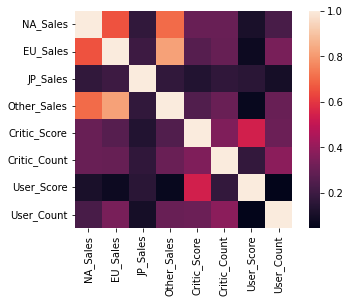

In [154]:
sns.heatmap(numeric_df.corr(), square=True)

In [155]:
pure_df = df.dropna(axis=0)
print(pure_df.shape)
pure_df.info()

(6825, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6825 non-null   object 
 1   Platform         6825 non-null   object 
 2   Year_of_Release  6825 non-null   float64
 3   Genre            6825 non-null   object 
 4   Publisher        6825 non-null   object 
 5   NA_Sales         6825 non-null   float64
 6   EU_Sales         6825 non-null   float64
 7   JP_Sales         6825 non-null   float64
 8   Other_Sales      6825 non-null   float64
 9   Global_Sales     6825 non-null   float64
 10  Critic_Score     6825 non-null   float64
 11  Critic_Count     6825 non-null   float64
 12  User_Score       6825 non-null   float64
 13  User_Count       6825 non-null   float64
 14  Developer        6825 non-null   object 
 15  Rating           6825 non-null   object 
dtypes: float64(10), object(6)
memory usage: 906.4+ K

In [156]:
pure_df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,7.185626,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,1.439942,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,7.500000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,8.200000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,9.600000,10665.000000


In [157]:
pure_df_sample = remove_outliers(pure_df).sample(frac=0.2, random_state=randomness_id)
pure_df_sample.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,2007.429688,0.286477,0.155187,0.034250,0.054961,0.530945,70.225000,27.992969,7.320000,101.845313
std,4.096154,0.391371,0.252045,0.105745,0.089756,0.684941,12.819222,17.453769,1.247248,222.591046
min,1997.000000,0.000000,0.000000,0.000000,0.000000,0.010000,30.000000,4.000000,2.900000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.120000,62.000000,14.000000,6.700000,10.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.280000,72.000000,24.000000,7.600000,24.000000
75%,2010.000000,0.350000,0.180000,0.010000,0.060000,0.650000,80.000000,38.000000,8.200000,79.000000
max,2016.000000,3.000000,2.150000,0.880000,0.750000,6.050000,98.000000,85.000000,9.400000,1849.000000


## Plot features pair

In [158]:
def plot_two_numeric_features_k_means(df, feat1, feat2, plot_labels_for_k=2):
    df = df[[feat1, feat2]]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    k_range = range(1, 11)
    sum_of_squared_distances = list()
    labels = None
    centroids = None
    for k in k_range:
        km = KMeans(n_clusters=k, init="k-means++", random_state=randomness_id).fit(scaled_data)
        sum_of_squared_distances.append(km.inertia_)
        if (plot_labels_for_k == k):
            labels = km.labels_
            centroids = scaler.inverse_transform(km.cluster_centers_)
    # region Plot square errors
    plt.plot(k_range, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    # endregion Plot square errors
    # region Plot labels
    unique_labels = np.unique(labels)
    for i in unique_labels:
        plt.scatter(df.values[labels == i, 0], df.values[labels == i, 1], label=i)
    plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.legend()
    plt.show()
    # endregion Plot labels

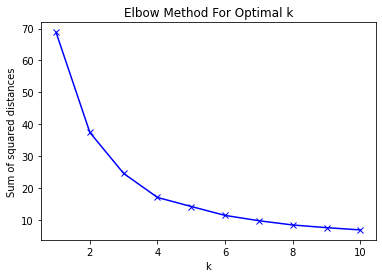

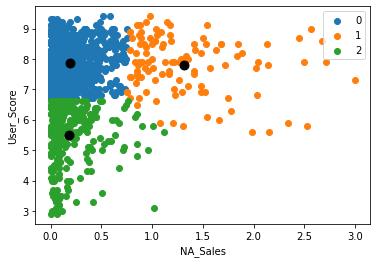

In [159]:
plot_two_numeric_features_k_means(pure_df_sample, "NA_Sales", "User_Score", plot_labels_for_k=3)

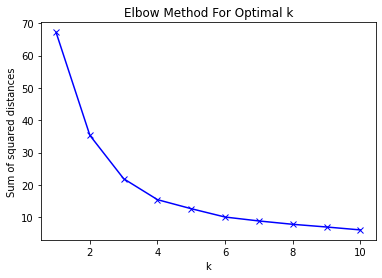

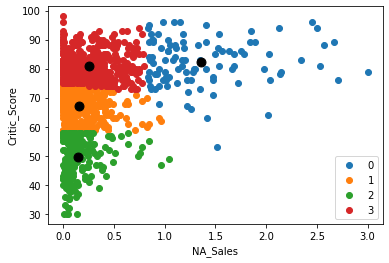

In [160]:
plot_two_numeric_features_k_means(pure_df_sample, "NA_Sales", "Critic_Score", plot_labels_for_k=4)

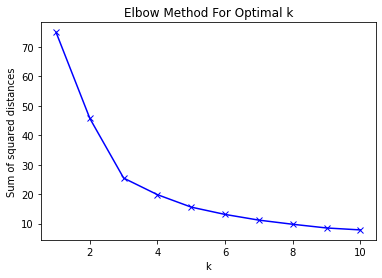

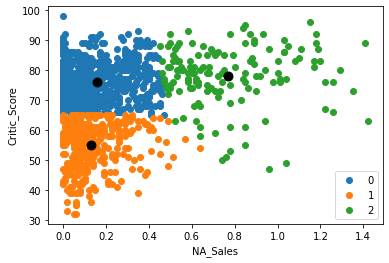

In [161]:
plot_two_numeric_features_k_means(remove_outliers(pure_df_sample), "NA_Sales", "Critic_Score", plot_labels_for_k=3)

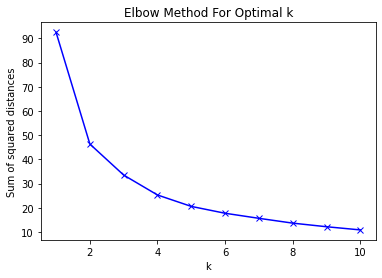

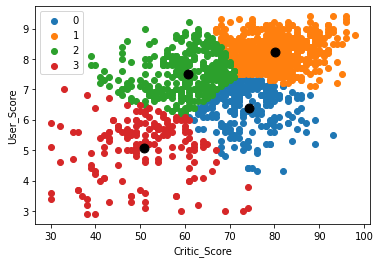

In [162]:
plot_two_numeric_features_k_means(pure_df_sample, "Critic_Score", "User_Score", plot_labels_for_k=4)

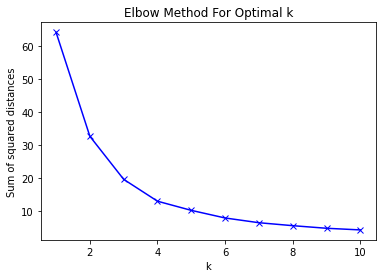

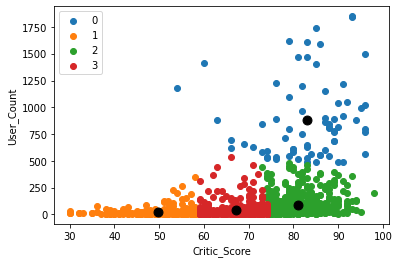

In [163]:
plot_two_numeric_features_k_means(pure_df_sample, "Critic_Score", "User_Count", plot_labels_for_k=4)

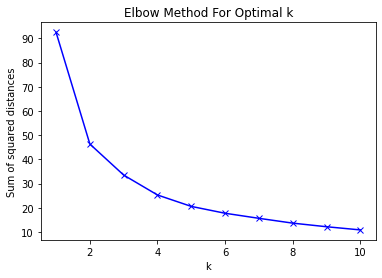

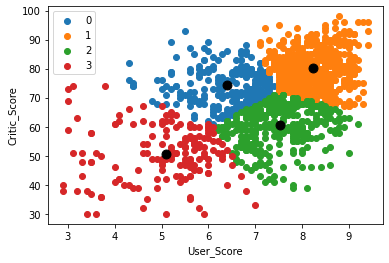

In [164]:
plot_two_numeric_features_k_means(pure_df_sample, "User_Score", "Critic_Score", plot_labels_for_k=4)

## K-means with multiple selected features

In [165]:
def plot_k_means_elbow_for_selected_features(df, continuous_features, categorical_features):
    df = df[[*continuous_features, *categorical_features]]
    for col in categorical_features:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    print(df.shape)
    scaled_data = MinMaxScaler().fit_transform(df)
    k_range = range(1, 11)
    sum_of_squared_distances = []
    for k in k_range:
        km = KMeans(n_clusters=k, init="k-means++", random_state=randomness_id).fit(scaled_data)
        sum_of_squared_distances.append(km.inertia_)
    plt.plot(k_range, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [166]:
pure_df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

### All quantifiable features

(1280, 746)


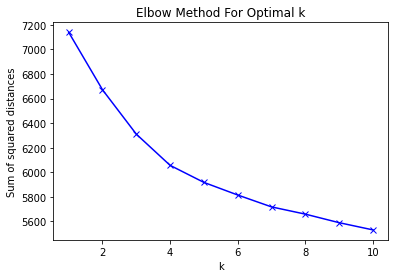

In [167]:
continuous_features = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score", "Critic_Count", "User_Score",
                       "User_Count"]
categorical_features = ["Platform", "Year_of_Release", "Genre", "Publisher", "Developer", "Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 8)


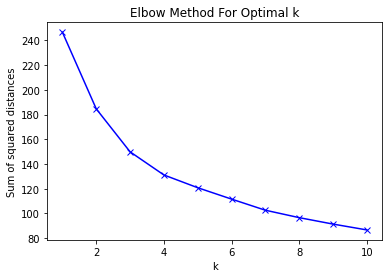

In [168]:
continuous_features = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Critic_Score", "Critic_Count", "User_Score",
                       "User_Count"]
categorical_features = []
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 738)


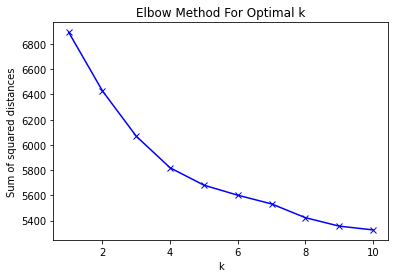

In [169]:
continuous_features = []
categorical_features = ["Platform", "Year_of_Release", "Genre", "Publisher", "Developer", "Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 20)


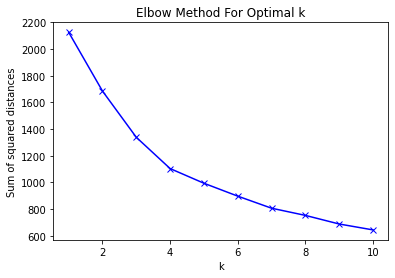

In [170]:
continuous_features = ["Global_Sales", "Critic_Score", "User_Count"]
categorical_features = ["Genre", "Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 17)


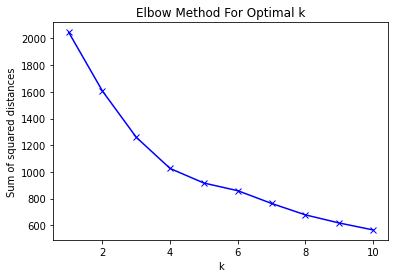

In [171]:
continuous_features = []
categorical_features = ["Genre", "Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 23)


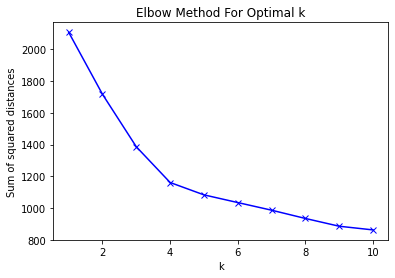

In [172]:
continuous_features = ["Global_Sales"]
categorical_features = ["Platform", "Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 7)


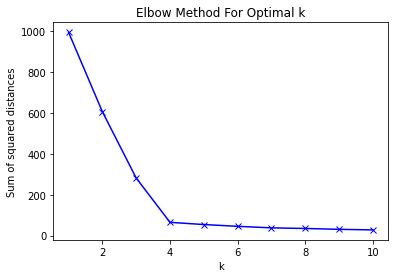

In [173]:
continuous_features = ["Global_Sales", "User_Score"]
categorical_features = ["Rating"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

(1280, 19)


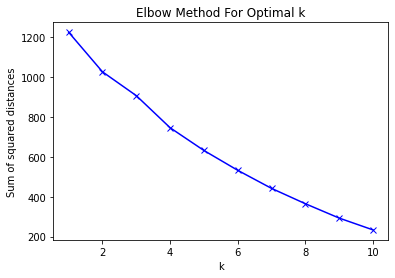

In [174]:
continuous_features = ["Global_Sales", "User_Score"]
categorical_features = ["Platform"]
plot_k_means_elbow_for_selected_features(pure_df_sample, continuous_features, categorical_features)

### PCA

In [175]:
def pca_k_means(df, show_plot_for_k=4):
    df = df.copy()
    """
    :type df: pd.DataFrame
    """
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_features:
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    print(df.shape)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    pca = PCA(3, random_state=randomness_id)
    pca_data = pca.fit_transform(scaled_data)
    k_range = range(1, 11)
    sum_of_squared_distances = list()
    cluster_labels = None
    centroids = None
    for k in k_range:
        km = KMeans(n_clusters=k, init="k-means++", random_state=randomness_id).fit(pca_data)
        sum_of_squared_distances.append(km.inertia_)
        if k == show_plot_for_k:
            cluster_labels = km.labels_
            centroids = km.cluster_centers_
    plt.plot(k_range, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for i in np.unique(cluster_labels):
        ax.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], pca_data[cluster_labels == i, 2],
                   s=40,
                   label=f"Cluster {i}")
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=80, color='k')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.view_init(30, 0)
    plt.show()
    def animate(frame):
        ax.view_init(30, frame * 3)
        plt.pause(.0001)
        return fig
    anim = animation.FuncAnimation(fig, animate, frames=15, interval=100, cache_frame_data=False)
    plt.close()
    display(HTML(anim.to_jshtml(default_mode="reflect")))
    # display(HTML(anim.to_html5_video(embed_limit=10)))
    return cluster_labels

def get_all_categorical_columns (df):
    return df.select_dtypes(include=['object']).columns.tolist()

In [176]:
print(f"Categorical features: {get_all_categorical_columns(pure_df_sample)}.")
display(pure_df_sample[get_all_categorical_columns(pure_df_sample)].nunique())
new_df = pure_df_sample.drop(["Name", 'Developer', "Publisher"], axis=1)
display(new_df[get_all_categorical_columns(new_df)].nunique())

Categorical features: ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating'].


Name         1150
Platform       17
Genre          12
Publisher     133
Developer     551
Rating          5
dtype: int64

Platform    17
Genre       12
Rating       5
dtype: int64

(1280, 44)


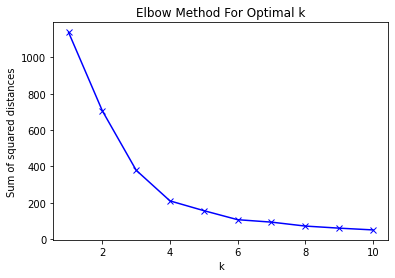

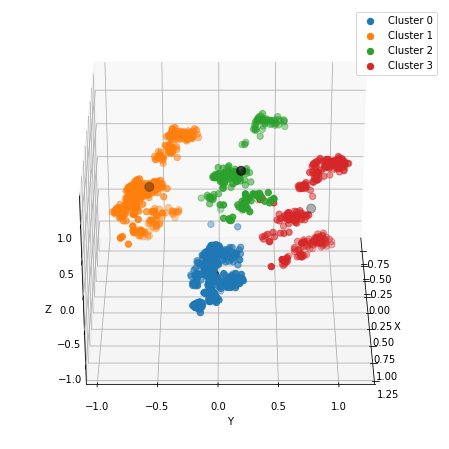

In [177]:
cluster_labels = pca_k_means(new_df)